In [1]:
!nvidia-smi

Thu Sep  9 15:33:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8     3W /  N/A |    480MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.getcwd()

'C:\\Users\\hongr\\OneDrive\\바탕 화면\\이미지 데이터 증폭 학습'

# 전이학습을 수행할 신경망 모바일넷2 불러오기 

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os 
import csv

from PIL import Image

In [5]:
%pwd

'C:\\Users\\hongr\\OneDrive\\바탕 화면\\이미지 데이터 증폭 학습'

In [6]:
label_text = pd.read_csv('../이미지 데이터 증폭 학습/dogs/labels.csv')
print(label_text.head(10))
print(label_text.info())

                                 id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None


# 종속변수의 범주가 몇가지 인지 확인

In [7]:
label_text['breed'].nunique()

120

In [8]:
image_id = label_text.loc[0,'id']
print("image_id : ", image_id)

image_id :  000bec180eb18c7604dcecc8fe0dba07


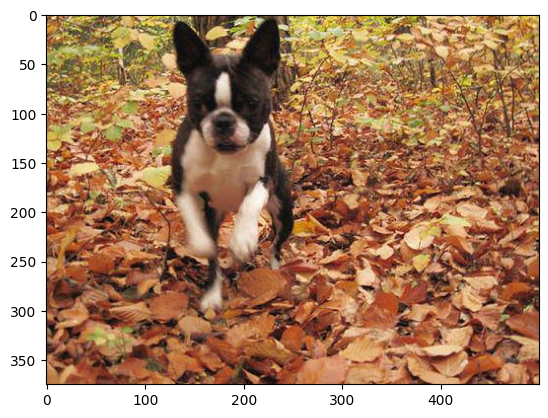

In [9]:
plt.imshow(plt.imread('../이미지 데이터 증폭 학습/dogs/train/'+ image_id + '.jpg'))
plt.show()

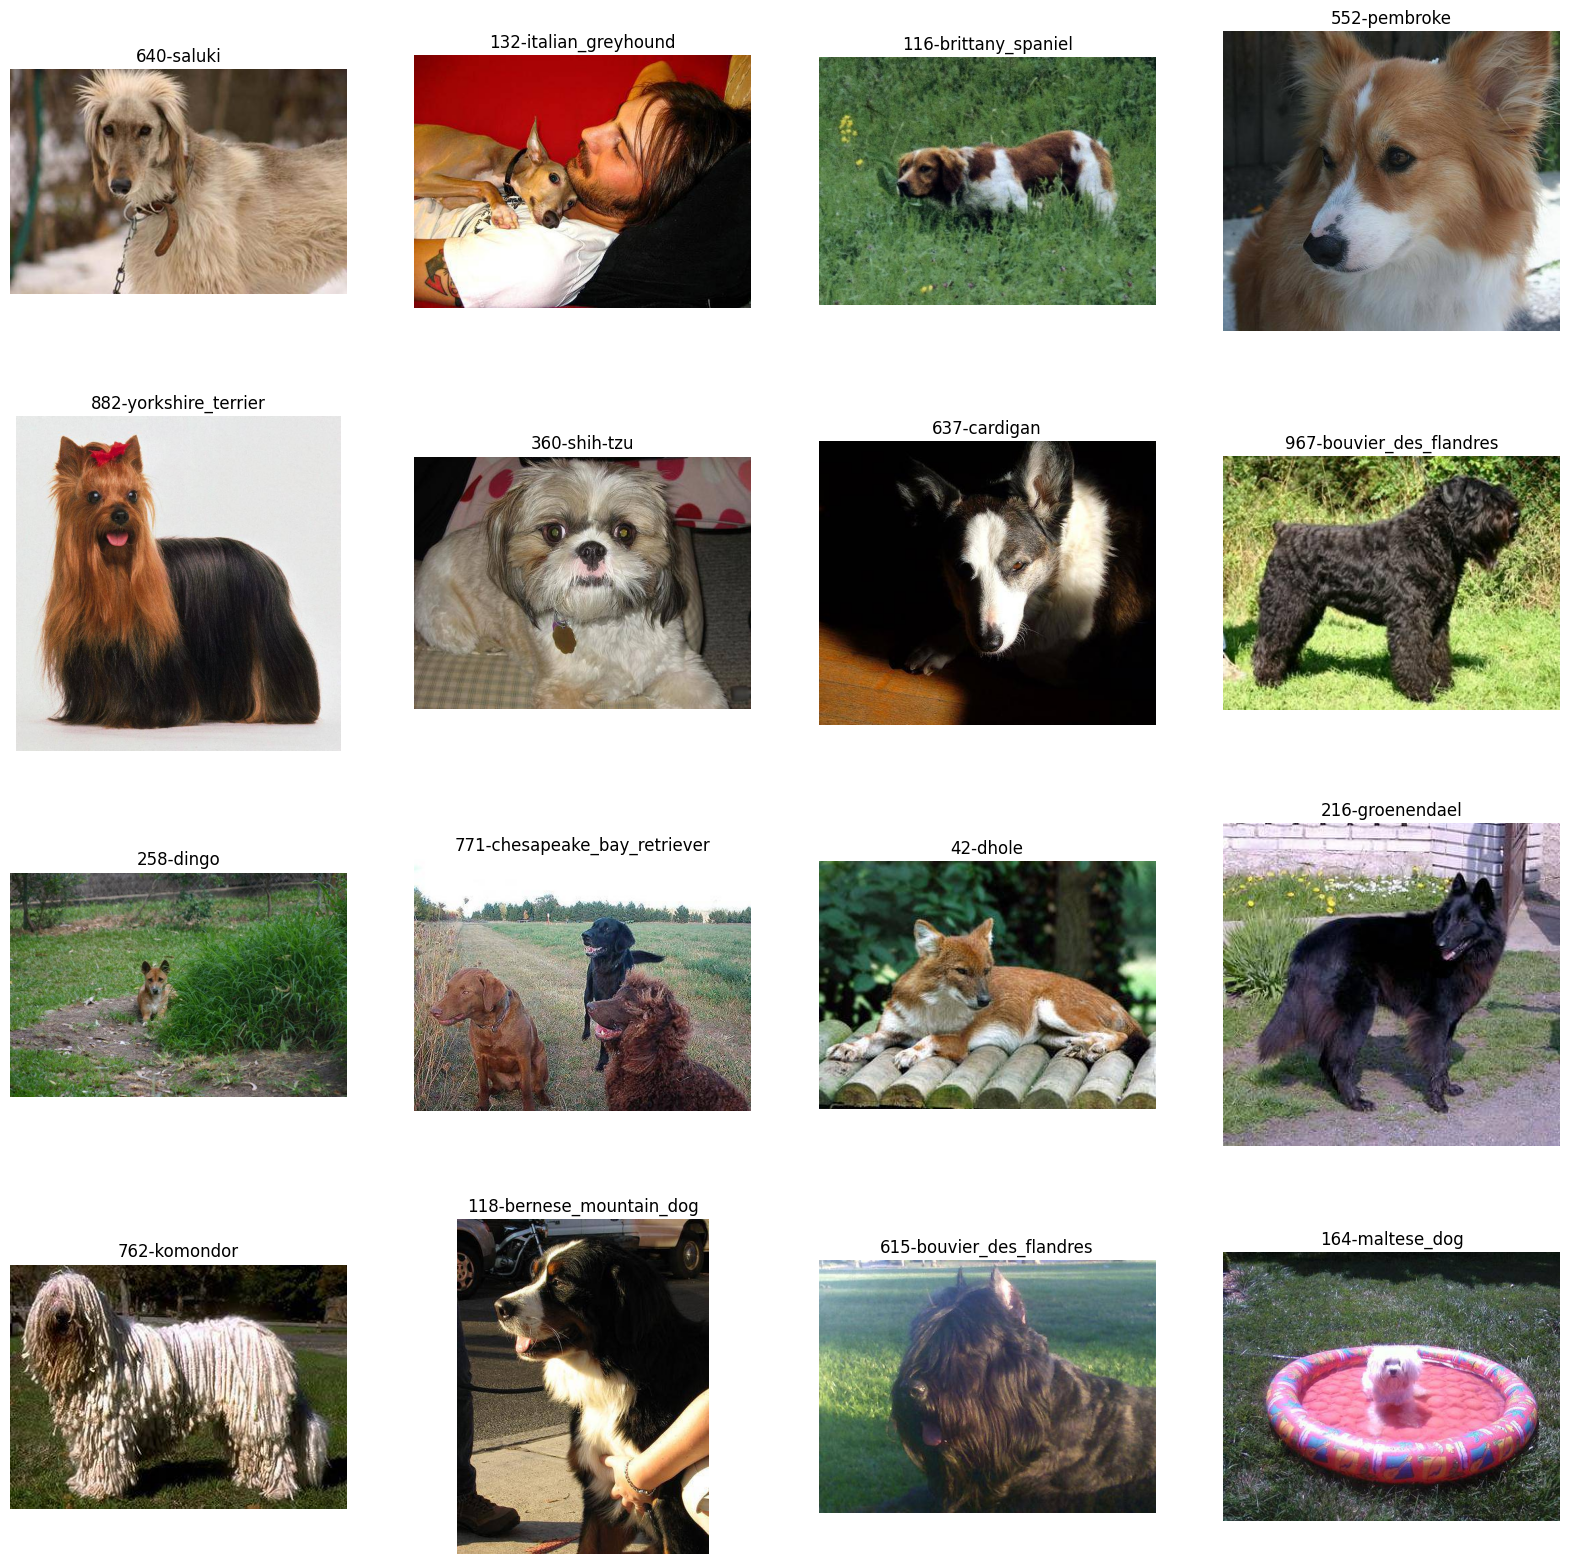

In [10]:
# 사진당 크기 
plt.figure(figsize=(20,20))

# 총 16장의 사진을 출력 
for i in range(16):

    # 가로 4개 세로 4개씩 하여 이미지를 출력합니다.
    plt.subplot(4,4,i+1)

    # 무작위 값을 주어 매번 다른 이미지가 출력되도록 합니다.
    i = np.random.choice(1000)

    #label_text 변수에 loc를 사용하여 
    # [i번 째 행,'id' 라는 열] 의 값을 할당합니다.
    image_id = label_text.loc[i, 'id']

    #절대경로 설정을 활용하여 사진 출력
    # 이미지 불러오는 과정에서 경로를 꼭 확인하세요.
    plt.imshow(plt.imread('../이미지 데이터 증폭 학습/dogs/train/' + image_id + '.jpg'))

    #사진과 함께 번호(i) + 제목 ( loc[i,'breed'] ) 출력
    plt.title(str(i) + '-' + label_text.loc[i, 'breed'])

    # 축 정보 표기 x
    plt.axis('off')

plt.show()

# 전이학습을 위한 2가지 실험

1. 가지고 온 신경망의 모든 계층의 가중치를 초기화
    * 모든계층을 다시 학습시켜준다. (학습을 시켜도 성능이 뛰어나지 않음)
2. 가지고 온 신경망의 계층 중 절반의 계층만 학습을 시켜준다

In [11]:
mobile_v2 = MobileNetV2()
mobile_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

신경망을 가지고 와서 처리가 안됐기 때문에 유닛값이 1000이다 


depthwise때문에 파라미터개수(350만개)가 생각보다 적다.

### 모든 계층을 학습 가능하도록 설정

In [12]:
# 하나씩 layer를 받는다.
#-1 인덱스를 제외한 이유: 학습을 시키지 않는다.
for layer in mobile_v2.layers[:-1]:
    layer.trainable = True

In [13]:
# 텐서플로우도 초기 파라미터의 값을 원하는 방식으로 초기화 시켜주는 과정..weight와 bias에 대한 초기 값을 설정한다.

In [14]:
for layer in mobile_v2.layers[:-1]:
    #가중치가 있는지 확인한다
    #만약 lyaer에 가중치(kernel)이 있다면
    if 'kernel' in layer.__dict__:
        
        #가중치를 '표준정규분포'에 해당하는 무작위값으로 설정하기 위해
        #현재 가지고있는 가중치의 shape값을 확인한다
        kernel_shape = np.array(layer.get_weights()).shape
        
        
        #가중치를 바꿔준다
        layer.set_weights(np.random.normal(0,1,size=kernel_shape))

### 이미지 데이터를 [224,224,4]으로 맞춰주고, min-max(정규화)과정을 진행한다

* 이때 에러가 나기 때문에 커널을 초기화 시켜줘야한다

In [15]:
train_X = []

for i in range(len(label_text)): # 모든 이미지개수 만큼 반복 수행
    #이미지 읽어들이기(경로설정을 주의)
    img = cv2.imread('../이미지 데이터 증폭 학습/dogs/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224, 224)) # 이미지 크기 통일
    
    img = img / 255.0 # 이미지 크기 최소-최대 정규화
    #(이미지 크기 축소)
    
    train_X.append(img) # 빈 리스트에 학습 데이터 생성

train_X = np.array(train_X) # 학습 데이터를 array 타입으로 전환 

# 얻어진 학습 데이터의 shape 확인 
print(train_X.shape)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [17]:
label_text #종류 120개를 모두 원핫벡터 처리하는 것보다 연속형변수로 설정하는 것이 낫다.

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

### 중복되는 변수를 없애준다

In [20]:
unique_Y = label_text['breed'].unique().tolist()
print(unique_Y)
print(len(unique_Y))

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

### 각 종속변수에 넘버링을 취해준다

In [28]:
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y

[0,
 1,
 2,
 3,
 4,
 5,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 3,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 19,
 5,
 1,
 4,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 10,
 28,
 29,
 4,
 0,
 30,
 16,
 21,
 31,
 1,
 24,
 32,
 33,
 16,
 34,
 35,
 13,
 21,
 10,
 21,
 14,
 29,
 24,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 39,
 47,
 48,
 49,
 50,
 27,
 51,
 52,
 53,
 50,
 46,
 8,
 54,
 55,
 56,
 57,
 58,
 33,
 59,
 28,
 54,
 37,
 11,
 47,
 60,
 20,
 61,
 27,
 14,
 60,
 16,
 17,
 44,
 62,
 63,
 14,
 27,
 64,
 29,
 65,
 37,
 44,
 59,
 64,
 66,
 1,
 45,
 63,
 50,
 66,
 67,
 3,
 37,
 37,
 54,
 57,
 49,
 68,
 49,
 4,
 44,
 69,
 2,
 70,
 71,
 31,
 72,
 16,
 53,
 45,
 73,
 10,
 30,
 36,
 33,
 69,
 23,
 45,
 74,
 75,
 76,
 64,
 6,
 76,
 10,
 77,
 5,
 78,
 20,
 23,
 19,
 30,
 32,
 8,
 79,
 56,
 11,
 67,
 40,
 73,
 6,
 80,
 81,
 82,
 24,
 83,
 48,
 68,
 10,
 35,
 66,
 55,
 27,
 84,
 85,
 13,
 86,
 22,
 72,
 85,
 87,
 88,
 89,
 52,
 18,
 26,
 24,
 47,
 57,
 33,
 89,
 61,
 40,
 7,
 89,
 47,
 72,
 90

In [29]:
train_Y = np.array(train_Y)

*  마지막 계층을 가지고 올수없다. 노드 개수가 다르기 때문이고, 이 마지막 계층을 새롭게 정의해야 한다.
*  출력 계층 재정의 및 신경망 재구축

# 함수형 방식으로 출력 계층 재정의

In [33]:

#마지막 계층 이전의 계층(layer)[-2]이 필요하기 때문에
#변수화 시켜준다
output_layer_2 = mobile_v2.layers[-2].output


#새롭게 설계된 출력계층(유닛값 120개)
#마지막계층과 그 전 계층
predictions = tf.keras.layers.Dense(units=120, activation='softmax')(output_layer_2)

                                    
#새로운 출력계층을 기존 mobile_net_v2 마지막 계층으로 설정해야 한다.

# model 함수는 입력,출력을 받는다
model = tf.keras.Model(inputs = mobile_v2.input, outputs = predictions)
                    
#마지막 계층 이전의 계층(layer)가 필요하다

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

* 마지막 계층이 120인것을 확인 할 수 있다.

### 컴파일 및 학습위해서 

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])  

* 'sparse_categorical_crossentropy' 를 쓰는 이유는 종속변수가 원핫인코딩이 아닌, 연속형(1,2,3,4..)으로 되어있기 때문이다

In [37]:
#만드는 과정에서 똑같은 폴더가 있다면 에러발생
os.makedirs('../이미지 데이터 증폭 학습/dogs/log/')
log_dir = '../이미지 데이터 증폭 학습/dogs/log/'

In [39]:
#학습
history = model.fit(train_X, train_Y,
                   epochs = 10,
                   validation_data = 0.25,
                   batch_size = 32,
                   callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5),
                                tf.keras.callbacks.TensorBoard(log_dir = log_dir,
                                                              histogram_freq = 1)])

AttributeError: 'list' object has no attribute 'shape'

### 실험을 이어나가서 전이학습을 위해서 가지고온 신경망의 절반만큼만 학습을 진행
* 절반은 얼려놓고 절반은 실행

In [ ]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

mobilev2        = MobileNetV2()
output_layer_2  = mobilev2.layers[-2].output
predictions     = tf.keras.layers.Dense(120, activation='softmax')(output_layer_2)

model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)
model.summary()

* 20개정도가 절반이다..

In [42]:
#처음과 중간 까지는 학습X

for layer in model.layers[:-20]:
    layer.trainable = False
    
#중간부터 끝까지 학습O    
for layer in model.layers[-20:]:
    layer.trainable = True

### sgd는 확률적 경사하강법
* 장점: 속도가 빠르다
* 단점: 안정성은 좀 떨어진다

In [43]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
#학습
history = model.fit(train_X, train_Y,
                    epochs = 10,
                    validation_data = 0.25,
                    batch_size = 32,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5),   # 조기중단
                                 tf.keras.callbacks.TensorBoard(log_dir = log_dir, # 콜백을 위한 함수 
                                                                histogram_freq = 1)])

Epoch 1/10


C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


ValueError: in user code:

    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\hongr\anaconda3\envs\test\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 0 input tensors. Inputs received: []


### 텐서보드로 확인

tensorboard --logdir=C:\Users\hongr\OneDrive\바탕 화면\이미지 데이터 증폭 학습\dogs\log